# Nadaraya Waston

In [1]:
import torch
from d2l import torch as d2l
from torch import nn

In [2]:
n_train = 50  # 训练样本数
x_train, _ = torch.sort(torch.rand(n_train) * 5)   # 排序后的训练样本

def f(x):
    return 2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))  # 训练样本的输出
x_test = torch.arange(0, 5, 0.1)  # 测试样本
y_truth = f(x_test)  # 测试样本的真实输出
n_test = len(x_test)  # 测试样本数
n_test

50

In [3]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'], xlim=[0,5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5)

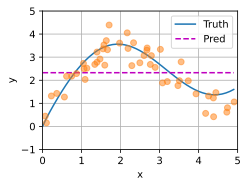

In [4]:
# y_hat为所有测试点的预测值，这里我们用训练标签的均值作为所有测试点的预测
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

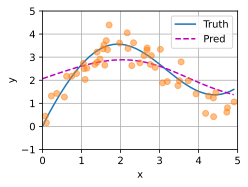

In [5]:
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 /2, dim=1)
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

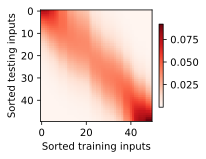

In [6]:
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0), xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

In [7]:
X = torch.ones((2,1,4))
Y = torch.ones((2,4,6))
torch.bmm(X,Y).shape

torch.Size([2, 1, 6])

In [8]:
weights = torch.ones((2,10))*0.1
values = torch.arange(20.0).reshape((2,10))
a = weights.unsqueeze(1)
b = values.unsqueeze(-1)
print(a,a.shape, b, b.shape)
torch.bmm(a, b)

tensor([[[0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
          0.1000, 0.1000]],

        [[0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
          0.1000, 0.1000]]]) torch.Size([2, 1, 10]) tensor([[[ 0.],
         [ 1.],
         [ 2.],
         [ 3.],
         [ 4.],
         [ 5.],
         [ 6.],
         [ 7.],
         [ 8.],
         [ 9.]],

        [[10.],
         [11.],
         [12.],
         [13.],
         [14.],
         [15.],
         [16.],
         [17.],
         [18.],
         [19.]]]) torch.Size([2, 10, 1])


tensor([[[ 4.5000]],

        [[14.5000]]])

In [9]:
# 带参数的 Nadaraya-Watson 核回归模型
# 这是注意力机制的原型：通过学习带宽参数 w 来控制注意力的集中程度
class NWKernelRegression(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        # w 是可学习的带宽参数，控制高斯核的宽度
        # w 越大 → 注意力越集中在最近的点
        # w 越小 → 注意力越分散，趋向于平均
        self.w = nn.Parameter(torch.rand((1,)), requires_grad=True)  # 注意是 requires_grad
    
    def forward(self, queries, keys, values):
        # queries: (n_queries,) 查询点
        # keys:    (n_queries, n_keys) 每个查询对应的参考点 x
        # values:  (n_queries, n_keys) 参考点对应的 y 值
        
        # Step 1: 扩展 queries 以匹配 keys 的形状
        # (n_queries,) → (n_queries, n_keys)
        # 例如 [q1, q2] → [[q1, q1, q1], [q2, q2, q2]]
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        
        # Step 2: 计算注意力权重（高斯核）
        # 公式: softmax(-((q - k) * w)² / 2)
        # 距离越近 → (q-k)² 越小 → 取负后越大 → softmax 后权重越高
        self.attention_weights = nn.functional.softmax(
            -((queries - keys) * self.w)**2/2, dim=1
        )
        
        # Step 3: 加权求和得到预测值
        # attention_weights: (n, n_keys) → unsqueeze(1) → (n, 1, n_keys)
        # values:            (n, n_keys) → unsqueeze(-1) → (n, n_keys, 1)
        # bmm 结果:          (n, 1, 1) → reshape(-1) → (n,)
        # 本质：对每个查询点，用注意力权重对 values 加权求和
        return torch.bmm(self.attention_weights.unsqueeze(1), values.unsqueeze(-1)).reshape(-1)

In [10]:
X_tile = x_train.repeat((n_train, 1))
Y_tile = y_train.repeat((n_train, 1))
keys = X_tile[(1-torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
values = Y_tile[(1-torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

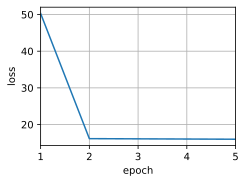

In [11]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1,5])

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))


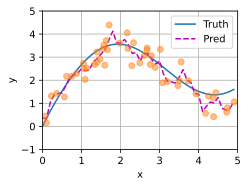

In [12]:
# 这里 repeat((n_test, 1)) 的意思是把 x_train 按行复制 n_test 次，得 shape (n_test, n_train)。
# 这样做是为了让每个测试样本都能与训练集中的所有 x 配对，方便之后进行核回归的批量计算。
keys = x_train.repeat((n_test, 1))
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

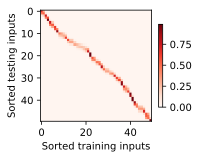

In [13]:
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')